In [ ]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import json
import os
from astropy.cosmology import Planck18
from scipy.fft import fft, fftfreq, ifft

# **Single Event Analysis**

### **Initialize GWFish: networks $\&$ waveforms**

1. We need to specify the network: list of detectors that work together (**detectors.yaml** file)
2. Parameters $\vec \theta$ describing the event we want to analyze as a DataFrame
3. Fisher parameters entering in the Fisher matrix
4. The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation** in `waveforms.py`(the default waveform class is in frequency domain) and from all the available waveforms in `inspiral_corrections.py`
5. For a more realistic analysis we can include the **duty cycle** of the detectors using `use_duty_cycle = True`

In [ ]:
# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']
detectors = ['ET']

# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))

use_duty_cycle = True # default is False anyway

################################################################################
# We can choose a waveform approximant class and model from waveforms.py or inspiral_corrections.py:
# gw.inspiral_corrections.IMRPhenomD_PPE
# gw.inspiral_corrections.TaylorF2_PPE
# gw.inspiral_corrections.IMRPhenomD_mult
# gw.inspiral_corrections.TaylorF2_mult
# gw.waveforms.LALFD_Waveform
# gw.waveforms.TaylorF2
# gw.waveforms.IMRPhenomD
################################################

### **How to create a single-event injection dictionary: GW150914**

**Injected parameters**

As said before, one can analyze single events or entire populations.

The parameters of a single event need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in [Msol] (in source frame)
- `mass_2`: secondary mass of the binary in [Msol] (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in [Mpc], usually one sets the redshift and calculates the corresponding luminosity distance using Planck18 cosmology
- `theta_jn`: the inclination angle between the line of observation and the perpendicular to the binary plane in [rad]
- `dec`: declination angle in [rad]
- `ra`: right ascension in [rad]
- `psi`: the polarization angle in [rad]
- `phase`: the initial phase of the merger in [rad]
- `geocent_time`: merger time as GPS time in [s]
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component

If the event is a BNS or BHNS (only lambda_1/2):
- `lambda_1`: dimensionless tidal polarizabilty of primary component
- `lambda_2`: dimensionless tidal polarizabilty of secondary component

If we want to consider ppE early-inspiral corrections:
- `beta`: amplitude coefficient of the phase correction
- `PN`: post-Newtonian order

or generalized early-inspiral corrections:
- `delta_phi_i`: amplitude coefficient of the phase correction at i = 2PN order

or multipolar (quadrupolar and octupolar) deviations:
- `k_1`: symmetric quadrupolar deviation
- `k_2`: antisymmetric quadrupolar deviation
- `lambda_1`: symmetric octupolar deviation
- `lambda_2`: antisymmetric octupolar deviation

or tidal deviations:
- `tilde`: deviation at 5PN
- `delta_tilde`: deviation at 6PN

We can also define:
- `tilt_1`: zenith angle between the spin and orbital angular momenta for the primary component in [rad]
- `tilt_2`: zenith angle between the spin and orbital angular momenta for the secondary component in [rad]
- `phi_12`: difference between total and orbital angular momentum azimuthal angles in [rad]
- `phi_jl`: difference between the azimuthal angles of the individual spin vector projections on to the orbital plane in [rad]

In [ ]:
import numpy as np

#Parameters dictionary
z = np.array([...])
parameters = {
    'mass_1': np.array([...]) * (1 + z), 'mass_2': np.array([...]) * (1 + z), #detector frame
    'a_1':np.array([...]), 'a_2':np.array([...]),
    'luminosity_distance': np.array([...]), 'theta_jn': np.array([...]),
    'geocent_time': np.array([...]), 'phase': np.array([...]), 'psi': np.array([...]),
    'ra': np.array([...]),'dec': np.array([...]),
    'tilt_1':np.array([...]), 'tilt_2':np.array([...]),
    'phi_jl':np.array([...]), 'phi_12':np.array([...]),
    'lambda_1':np.array([...]), 'lambda_2':np.array([...])
}
parameters = pd.DataFrame(parameters)

In [ ]:
#https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/

bin_file = '/content/GW150914_GWTC-1.hdf5'

with h5py.File(bin_file, 'r') as file:
    # Print the dataset names in .hdf5 file
    print("Dataset names:", list(file.keys()))

Dataset names: ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']


In [ ]:
#Choose the dataset
with h5py.File(bin_file, 'r') as file:
    bin_data = file['Overall_posterior'][:]

In [ ]:
#Show the posterior samples data
data=pd.DataFrame(bin_data)
data

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,spin1,spin2,costilt1,costilt2
0,-0.976633,517.176717,1.456176,-1.257815,39.037380,37.044563,0.417147,0.867740,-0.280624,0.403853
1,-0.700404,401.626864,2.658802,-0.874661,34.620096,34.184416,0.125709,0.260679,-0.757349,-0.312285
2,-0.840752,369.579071,1.106548,-1.136396,37.894343,33.970520,0.581047,0.926893,0.649781,-0.510843
3,-0.583657,386.935268,2.077180,-1.246351,36.412973,35.684463,0.235808,0.094391,0.116578,-0.720505
4,-0.928271,345.104345,0.993604,-1.069243,39.477251,31.645008,0.511521,0.868009,-0.438237,0.269333
...,...,...,...,...,...,...,...,...,...,...
8345,-0.691637,306.985025,1.485646,-1.269228,37.561962,33.355792,0.484003,0.627191,0.194507,-0.408345
8346,-0.834615,462.649414,2.065362,-1.265618,37.824298,36.674075,0.589654,0.650758,-0.737792,0.875384
8347,-0.911463,448.930876,1.536913,-1.257956,38.063291,35.757913,0.708407,0.714805,0.852085,-0.797475
8348,-0.856914,561.020036,2.367289,-1.211824,44.884396,31.592433,0.389284,0.521304,-0.251461,0.830526


In [ ]:
#Take the median or the mean of the posterior samples
mean_values = data.mean()
median_values = data.median()

parameters = pd.DataFrame(median_values)
parameters2 = pd.DataFrame(mean_values)

parameters, parameters2

(                                  0
 costheta_jn               -0.893325
 luminosity_distance_Mpc  439.298905
 right_ascension            1.676874
 declination               -1.214806
 m1_detector_frame_Msun    38.918565
 m2_detector_frame_Msun    33.458614
 spin1                      0.272104
 spin2                      0.333559
 costilt1                   0.031810
 costilt2                  -0.129647,
                                   0
 costheta_jn               -0.799226
 luminosity_distance_Mpc  436.498843
 right_ascension            1.706770
 declination               -1.179399
 m1_detector_frame_Msun    39.218637
 m2_detector_frame_Msun    33.102043
 spin1                      0.325860
 spin2                      0.371814
 costilt1                   0.026141
 costilt2                  -0.093227)

In [ ]:
#Parameters dictionary from /content/GW150914_GWTC-1.hdf5
z = np.array([0.088])
parameters = {
    'mass_1': np.array([35.77074]) * (1 + z),  #38.918565 in detector frame
    'mass_2': np.array([30.75240]) * (1 + z),  #33.458614 in detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.272104]),
    'a_2':np.array([0.333559]),

    'theta_jn': np.array([np.radians(153.2940853)]),
    'ra': np.array([1.676874]),
    'dec': np.array([-1.214806]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

#### **Injected parameters $\vec \theta$ and fisher parameters: GW150914**

In [ ]:
#Parameters dictionary from arXiv:1603.08955
z = np.array([0.088])
parameters = {
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'mass_1': np.array([35.7]),
    'mass_2': np.array([29.1]),
    'a_1':np.array([0.32]),
    'a_2':np.array([0.34]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

#Fisher parameters dictionary
fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance','theta_jn',
                     'dec','ra',
                     'psi','phase', 'geocent_time'    
                    ]
parameters

,redshift,luminosity_distance,mass_1,mass_2,a_1,a_2,theta_jn,ra,dec,psi,...,cut,beta,PN,delta_phi_8,k_1,k_2,lambda_1,lambda_2,tilde,delta_tilde
0,0.088,415.380325,35.7,29.1,0.32,0.34,2.420772,1.7,-1.2,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Some computations: $SNR$, $\delta \theta_i$ and $\Delta\Omega_{90\%}$ with `compute_network_errors`**

In [ ]:
# Example: ET network and IMRPhenomD template 

detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True,

waveform_class = gw.waveforms.LALFD
waveform_model = 'IMRPhenomD'

detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = network,
        parameter_values = parameters,
        fisher_parameters = fisher_parameters,
        waveform_model = waveform_model,
        waveform_class = waveform_class,
        )

print('\nThe network SNR of the event is ', network_snr)

100%|██████████| 1/1 [00:07<00:00,  7.84s/it]


The network SNR of the event is  [24.00567111]


In [ ]:
# One can create a dictionary using the parameter errors with the same fisher parameters order 

parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]
    
# Choose the waveform paramater
parameter_of_interest = 'mass_1'
print(parameter_errors_dict['err_' + parameter_of_interest])

35.103507545169784


In [ ]:
#If dec and ra are in the Fisher parameters dictionary:

print('The sky localization of the event is ', sky_localization, 'rad^2')
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
print('The sky localization at 90 % of the event is ', sky_localization_90cl,  'deg^2')

The sky localization of the event is  None rad^2


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

### **Signal-to-noise-ratio dependencies: $SNR$ vs $\theta_{i}$**

In [ ]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

#parameters are coherent with the ones used in arXiv:1603.08955
z = np.array([0.088])
parameters = {
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'mass_1': np.array([35.7]) * (1 + z),
    'mass_2': np.array([29.1]) * (1 + z),
    'a_1':np.array([0.]),
    'a_2':np.array([0.]),
    'theta_jn': np.array([2.68]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance', 'phase', 'geocent_time',
                     #'theta_jn',
                     'dec','ra',
                     'psi'
                    ]

waveform_class = gw.waveforms.LALFD
waveform_model = 'IMRPhenomD

# Choose the waveform parameter
parameter_of_interest = 'theta_jn'

with open('SNR_vs_' + parameter_of_interest + '.txt', 'w') as f:
    for theta in np.arange(0,3.5,0.1):
        parameters[parameter_of_interest] = theta

        detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
            network=network,
            parameter_values=parameters,
            fisher_parameters=fisher_parameters,
            waveform_model = waveform_model,
            waveform_class = waveform_class
        )
        network_snr_str = [str(snr) for snr in network_snr]
        f.write(" ".join(network_snr_str) + " " + str(theta) + "\n")

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


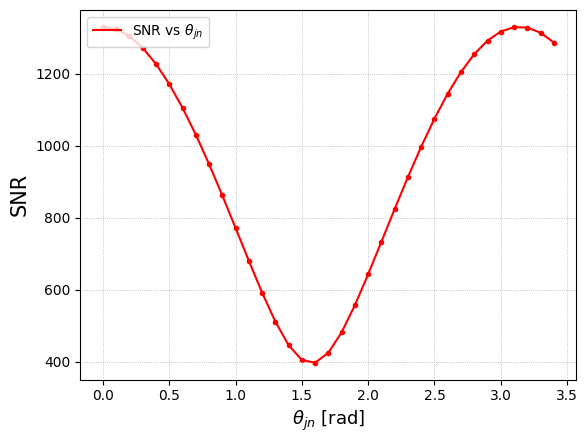

In [ ]:
# We can plot the results

data = np.loadtxt('SNR_vs_' + parameter_of_interest + '.txt')
x = data[:, 1]
y = data[:, 0]

fig, ax = plt.subplots()
ax.plot(x, y, color = 'red', linestyle='-', label = r'SNR vs' + parameter_of_interest)
ax.scatter(x, y, color='red', marker='.')
ax.set_xlabel(parameter_of_interest, fontsize=13)
ax.set_ylabel('SNR', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

## **ppE early inspiral deviations: single event analysis**

### SNR-luminosity distance test

In [ ]:
TaylorF2_results=[]

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    data_folder = 'Gwfish_results_TF2'
    gw.fishermatrix.analyze_and_save_to_txt(network=network_3,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0,1]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class_2,
                                            waveform_model=waveform_model_2,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')
    my_fisher = fisher_matrix[0, :, :]
    errors = pd.read_csv(data_folder + '/' + 'Errors_LLO_O1_LHO_O1_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors['network_SNR'].iloc[0] / ((my_fisher[4, 4]**(0.5))*errors['luminosity_distance'].iloc[0])

    TaylorF2_results.append((PN, snr_times_delta_dL))

# GWFish results
with open('SNR_test_TF2.txt', 'w') as f:
    for result in TaylorF2_results:
        f.write(f'{result[0]} {result[1]}\n')
################################################################################
IMRPhenomD_results=[]

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    data_folder = 'Gwfish_results_IMRD'
    gw.fishermatrix.analyze_and_save_to_txt(network=network_3,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0,1]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class,
                                            waveform_model=waveform_model,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')
    my_fisher = fisher_matrix[0, :, :]
    errors = pd.read_csv(data_folder + '/' + 'Errors_LLO_O1_LHO_O1_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors['network_SNR'].iloc[0] / ((my_fisher[4, 4]**(0.5))*errors['luminosity_distance'].iloc[0])

    IMRPhenomD_results.append((PN, snr_times_delta_dL))

# GWFish results
with open('SNR_test_IMRD.txt', 'w') as f:
    for result in IMRPhenomD_results:
        f.write(f'{result[0]} {result[1]}\n')

100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


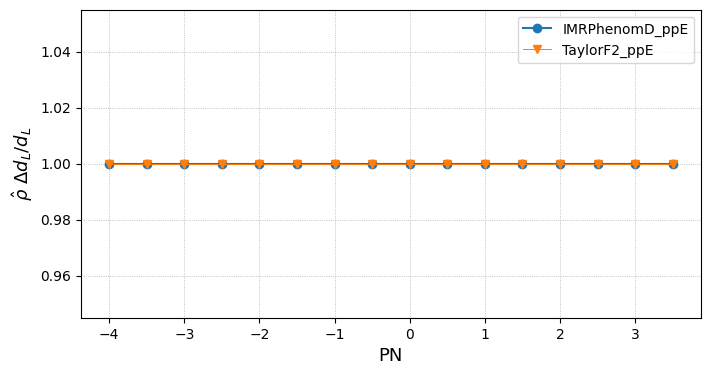

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

TaylorF2_results = np.loadtxt('SNR_test_TF2.txt')
IMRPhenomD_results = np.loadtxt('SNR_test_IMRD.txt')

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(IMRPhenomD_results[:,0], IMRPhenomD_results[:,1], marker='o', label='IMRPhenomD_ppE')
ax.plot(TaylorF2_results[:,0], TaylorF2_results[:,1], marker='v', linewidth=0.7, label='TaylorF2_ppE')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel(r'$\hat \rho \ \Delta d_L/d_L$', fontsize=13)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend()

#plt.savefig('SNR.pdf')
plt.show()

### *GW150914: comparison between TF2_ppE and IMR_ppE using the LIGO O1 network*

In [ ]:
detectors = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE

################################################################################
################################################################################
# Parameters dictionary from Properties of the Binary Black Hole Merger GW150914 (B. P. Abbott et al.)
# except for M1, M2, DL, a1, a2

z = 0.088
parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.]),
    'a_2':np.array([0.]),

    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),

    'cut': np.array([1.]), #f_cut = cut*f_isco 

    'beta':np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time'
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                     ,'beta'
                    ]

parameter_of_interest = 'beta'

# Errors as functions of the PN order
PN_min = -4.
PN_max = 4.

In [ ]:
################################################################################
################################################################################
results = []
results_2 = []

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    # Errors computation
    # IMR_ppE
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )
    # TF2_ppE
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )
    
    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([PN, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([PN, err_parameter_of_interest_2, network_snr_2])

################################################################################
################################################################################
results_df = pd.DataFrame(results, columns=['PN', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['PN', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)

file_name = f'errors_{detector_name}_{parameter_of_interest}_IMR.txt'
file_name_2 = f'errors_{detector_name}_{parameter_of_interest}_TF2.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


In [ ]:
data = np.loadtxt('errors_LLO_O1_LHO_O1_'f'{parameter_of_interest}_IMR.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_O1_LHO_O1_'f'{parameter_of_interest}_TF2.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

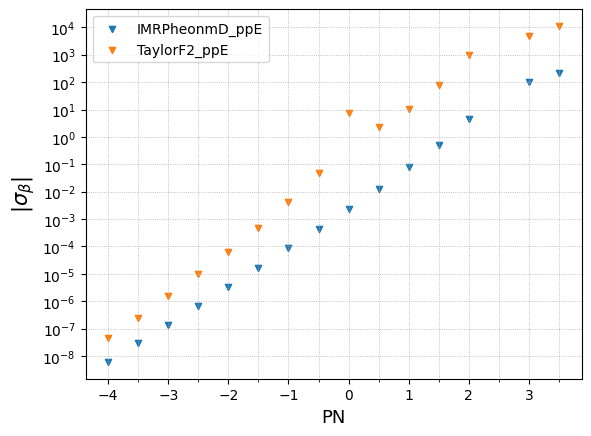

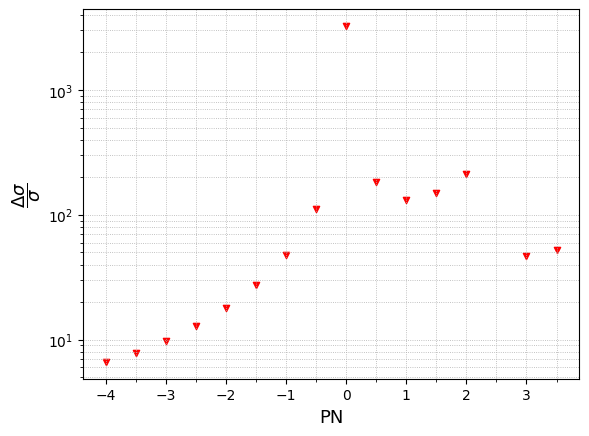

In [ ]:
import matplotlib.ticker as ticker

# We do not want to show the 2.5PN result
mask = (x != 2.5)
mask_2 = (x_2 != 2.5)
x = x[mask]
y = y[mask]
x_2 = x_2[mask_2]
y_2 = y_2[mask_2]

fig, ax = plt.subplots()

ax.scatter(x, y, marker='v', s=20, label = 'IMRPheonmD_ppE')
ax.scatter(x_2, y_2, marker='v',  s=20, label = 'TaylorF2_ppE')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.set_yscale('log')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.savefig('ppE.pdf')
plt.show()
################################################################################

fig, ax = plt.subplots()

delta_sigma = (y_2 - y)/y
ax.scatter(x, delta_sigma, marker='v',  s=20, color = 'red' ,label = r'$\dfrac{\Delta \sigma}{\sigma}$')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel(r'$\dfrac{\Delta \sigma}{\sigma}$', fontsize=13)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.set_yscale('log')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

#plt.savefig('ppE_difference.pdf')
plt.show()

#### 0PN correlations: corner plot

In [ ]:
detectors = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE

z = 0.088
PN = 0.
parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.]),
    'a_2':np.array([0.]),

    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),

    'cut': np.array([1.]),

    'beta':np.array([0.])
}

parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time',
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                     'beta'
                    ]

In [ ]:
data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0,1]],
                                        population_name = 'GW150914',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:17<00:00, 17.32s/it]


In [ ]:
! pip install -q corner
import corner

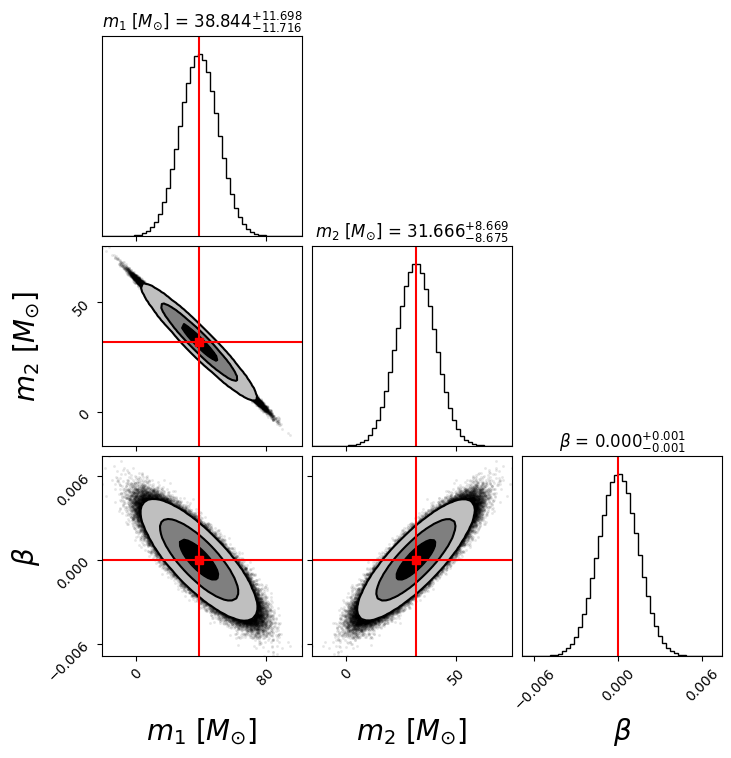

In [ ]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours.
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 20), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )

corner_lbs = [r'$m_1$ $[M_{\odot}]$', r'$m_2$ $[M_{\odot}]$',
              '$a_1$', '$a_2$',
              '$t_c$','$\phi_c$',
              '$D_l$ [Mpc]',
              r'$\beta$'
              ]

mean_lbs = ['mass_1', 'mass_2',
            'a_1', 'a_2',
            'geocent_time','phase',
            'luminosity_distance',
            'beta'
            ]

mean_values = parameters[mean_lbs].iloc[0]  #mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))


################################################################################
# Marginalization
selected_params = ['mass_1', 'mass_2',
                   #'a_1', 'a_2',
                   'beta']
selected_indices = [mean_lbs.index(param) for param in selected_params]
filtered_samples = samples[:, selected_indices]
filtered_labels = [corner_lbs[i] for i in selected_indices]
filtered_truths = mean_values[selected_params].values

fig = corner.corner(filtered_samples, labels=filtered_labels, truths=filtered_truths, truth_color='red', **CORNER_KWARGS)

#plt.savefig('corner_IMR.pdf')
plt.show()

### *GW150914: comparison between ET vs O5 using the IMR_ppE template*

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE

################################################################################
################################################################################
#Parameters dictionary from Properties of the Binary Black Hole Merger GW150914 (B. P. Abbott et al.)
#except for M1, M2, DL, a1, a2

z = 0.088
parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.]),
    'a_2':np.array([0.]),

    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),

    'cut': np.array([1.]),

    'beta':np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time',
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                      'beta'
                    ]

parameter_of_interest = 'beta'
PN_min = -4.
PN_max = 4.

results = []
results_2 = []
results_3 = []
results_4 = []

################################################################################
################################################################################

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    #Errors computation

    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([PN, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([PN, err_parameter_of_interest_2, network_snr_2])


################################################################################
################################################################################

results_df = pd.DataFrame(results, columns=['PN', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['PN', f'err_{parameter_of_interest}_2', 'network_snr_2'])


#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)

file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

In [ ]:
data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

data_3 = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

In [ ]:
import matplotlib.ticker as ticker

mask_2 = (x_2 != 2.5)
mask_3 = (x_3 != 2.5)

x_2 = x_2[mask_2]
y_2 = y_2[mask_2]

x_3 = x_3[mask_3]
y_3 = y_3[mask_3]


fig, ax = plt.subplots()

# Plot dei punti
ax.plot(x_2, y_2, color = 'green', linestyle='-', linewidth='0.7', label = 'LIGO O5 & IMRPhenomD')
ax.plot(x_3, y_3, color = 'blue', linestyle='-', linewidth='0.7', label = 'ET & IMRPhenomD')

ax.scatter(x_2, y_2, color='green', marker='.')
ax.scatter(x_3, y_3, color='blue', marker='.')


# Impostazioni degli assi e del titolo
ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=15)

# Attiva la legenda e la griglia
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

# Imposta la scala logaritmica sull'asse y
ax.set_yscale('log')

# Aggiunge dei tick intermedi sull'asse x e y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.savefig('ppE.pdf')
# Mostra il grafico
plt.show()

### *Constraints as functions of the total mass M*

In [ ]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE
waveform_model = 'IMRPhenomD_PPE'

z = 0.088

parameters_1 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    #'cut': np.array([1.]),
    'PN': np.array([-1.]),
    'beta': np.array([0.])
    }
parameters_1 = pd.DataFrame(parameters_1)


parameters_2 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    #'cut': np.array([1.]),
    'PN': np.array([0.]),
    'beta': np.array([0.])
    }
parameters_2 = pd.DataFrame(parameters_2)


parameters_3 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    #'cut': np.array([1.]),
    'PN': np.array([2.]),
    'beta': np.array([0.])
    }
parameters_3 = pd.DataFrame(parameters_3)


fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time',
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                     'beta'
                    ]

# Definizione dei valori di massa
mass_ratio = 2.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

parameter_of_interest = 'beta'

results = []
results_2 = []
results_3 = []

#Mass values
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    parameters_1['mass_1'] = parameters_2['mass_1'] = parameters_3['mass_1'] = mass_1 * (1 + z)
    parameters_1['mass_2'] = parameters_2['mass_2'] = parameters_3['mass_2'] = mass_2 * (1 + z)

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_1,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_2,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_3, network_snr_3, parameter_errors_3, sky_localization_3 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_3,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = 1.645*np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645*np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

    err_parameter_of_interest_3 = 1.645*np.squeeze(parameter_errors_3)[fisher_parameters.index(parameter_of_interest)]
    results_3.append([mass_tot, err_parameter_of_interest_3, network_snr_3])


results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])
results_df_3 = pd.DataFrame(results_3, columns=['mass_tot', f'err_{parameter_of_interest}_3', 'network_snr_3'])

#Storage
detector_name = '_'.join(detectors)
file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name}_{parameter_of_interest}_2.txt'
file_name_3 = f'errors_{detector_name}_{parameter_of_interest}_3.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)
results_df_3.to_csv(file_name_3, sep='\t', index=False)

100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


In [ ]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_ET_'f'{parameter_of_interest}_2.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

data_3 = np.loadtxt('errors_ET_'f'{parameter_of_interest}_3.txt', skiprows=1, usecols=(0, 1))

x3 = data_3[:, 0]
y3 = data_3[:, 1]

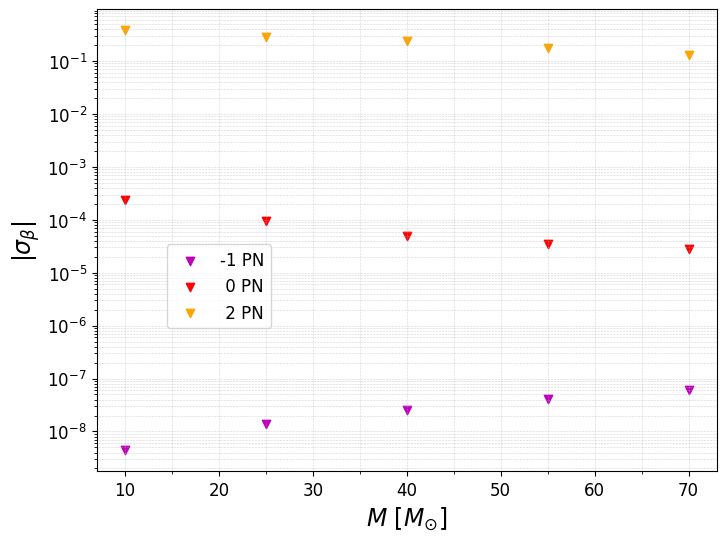

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

# Traccia i dati
ax.scatter(x, y, marker='v', color='m', label='-1 PN')
#ax.plot(x, y, linestyle='-', linewidth='0.7', color='m', label='-1PN')
ax.scatter(x2, y2, marker='v', color='r', label=' 0 PN')
#ax.plot(x2, y2, linestyle='-', linewidth='0.7', color='r', label='0PN')
ax.scatter(x3, y3, marker='v', color='orange', label=' 2 PN')
#ax.plot(x3, y3, linestyle='-', linewidth='0.7', color='orange', label='2PN')
#ax.scatter(x4, y4, marker='s', color='b', facecolors='none', label='LIGO O5, Bayesian')

# Etichetta gli assi
ax.set_xlabel('$M$ $[M_{\odot}]$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=17)
#ax.set_ylim(10**1, 10**3)

ax.set_yscale('log')
ax.legend(loc='center left', fontsize=12, ncol=1, fancybox=True, bbox_to_anchor=(0.1, 0.4))
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

# Mostra il grafico
plt.grid(True)
plt.savefig('beta_vs_M.pdf')
plt.show()

## **|$\sigma_{\delta \phi_i}$| vs $PN$ in a single event analysis**

### *GW150914 LIGO O1 comparison between GWFISH and BILBY*

In [ ]:
detectors_3 = ['LLO_O1','LHO_O1']
network_3 = gw.detection.Network(detector_ids = detectors_3, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE

z = np.array([0.088])
i = 0.

i_min = 0
i_max = 11

results = []

for i in np.arange(i_min, i_max, 1):
    if i == 5:
        continue  # Salta l'iterazione quando i = 5

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': np.array([410.]),
    'a_1': np.array([0.32]),
    #'a_1': np.array([0.]),
    'a_2': np.array([0.44]),
    #'a_2': np.array([0.]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network_3,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])


results_df = pd.DataFrame(results, columns=['i', f'err_delta_phi', 'network_snr'])


#Storage
detector_name = '_'.join(detectors_3)

file_name = f'errors_{detector_name}_delta_phi.txt'

results_df.to_csv(file_name, sep='\t', index=False)

#delta_phi_8=delta_phi_2.5log
#delta_phi_9=delta_phi_3log
#delta_phi_10=delta_phi_-1

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


In [ ]:
data = np.loadtxt('errors_LLO_O1_LHO_O1_delta_phi.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('ppE LIGO O1.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

data_3 = np.loadtxt('errors_LLO_O1_LHO_O1_delta_phi_w_priors.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

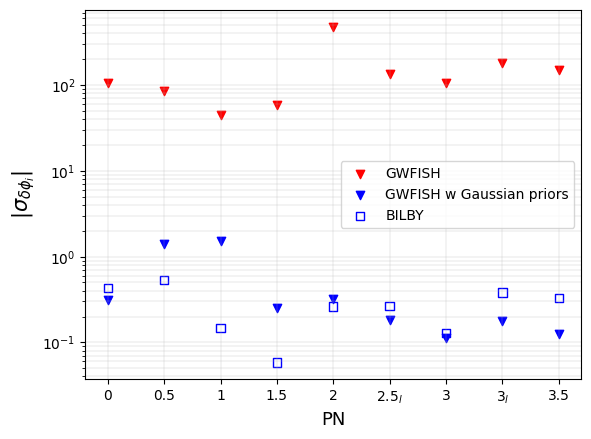

In [ ]:
import matplotlib.ticker as ticker

# Definisci nomi personalizzati per ciascun punto sull'asse x
custom_x_labels = [ '0', '0.5', '1', '1.5', '2', '2.5$_{l}$', '3', '3$_{l}$', '3.5']

fig, ax = plt.subplots()

# Plot dei punti
ax.scatter(x, y, color='red', marker='v', label = 'GWFISH')
ax.scatter(x_3, y_3, color='blue', marker='v' ,label = 'GWFISH w Gaussian priors')
ax.scatter(x_2, y_2, color='blue', marker='s', facecolors='none' ,label = 'BILBY')

# Impostazioni degli assi e del titolo
ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\delta \phi_i}|$', fontsize=15)

# Attiva la legenda e la griglia
ax.legend(loc='center right', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='-', linewidth='0.2', which='both')

# Imposta nomi personalizzati sull'asse x
ax.set_xticks(x)
ax.set_xticklabels(custom_x_labels)

# Imposta la scala logaritmica sull'asse y
ax.set_yscale('log')

plt.savefig('ppE_GWFISH_vs_BILBY.pdf')
# Mostra il grafico
plt.show()

### *GW150914 comparison between ET vs LIGO/CE*

In [ ]:
detectors = ['ET']
#detectors_2 = ['LLO','LHO']
detectors_2 = ['CE1', 'CE2']
#detectors_3 = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
#network_3 = gw.detection.Network(detector_ids = detectors_3, detection_SNR = (0., 8.))


waveform_model_2 = 'IMRPhenomD_PPE'
waveform_class_2 = gw.inspiral_corrections.IMRPhenomD_PPE

z = np.array([0.088])
i = 0.

i_min = 0
i_max = 11

results = []
results_2 = []

for i in np.arange(i_min, i_max, 1):
    if i == 5:
        continue  # Salta l'iterazione quando i = 5

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([i, err_parameter_of_interest_2, network_snr_2])

"""
        detected_3, network_snr_3, parameter_errors_3, sky_localization_3 = gw.fishermatrix.compute_network_errors(
        network=network_3,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest_3 = 1.645 * np.squeeze(parameter_errors_3)[fisher_parameters.index(parameter_of_interest)]
    results_3.append([i, err_parameter_of_interest_3, network_snr_3])
"""

results_df = pd.DataFrame(results, columns=['i', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['i', f'err_{parameter_of_interest}_2', 'network_snr_2'])
#results_df_3 = pd.DataFrame(results_3, columns=['i', f'err_{parameter_of_interest}_3', 'network_snr_3'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
#detector_name_3 = '_'.join(detectors_3)

file_name = f'errors_{detector_name}_delta_phi.txt'
file_name_2 = f'errors_{detector_name_2}_delta_phi.txt'
#file_name_3 = f'errors_{detector_name_3}_delta_phi.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)
#results_df_3.to_csv(file_name_3, sep='\t', index=False)

100%|██████████| 1/1 [00:11<00:00, 11.49s/it]


In [ ]:
data_2 = np.loadtxt('errors_CE1_CE2_delta_phi.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]


data_4 = np.loadtxt('errors_LLO_LHO_delta_phi.txt', skiprows=1, usecols=(0, 1))

x_4 = data_4[:, 0]
y_4 = data_4[:, 1]


data_3 = np.loadtxt('errors_ET_delta_phi.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

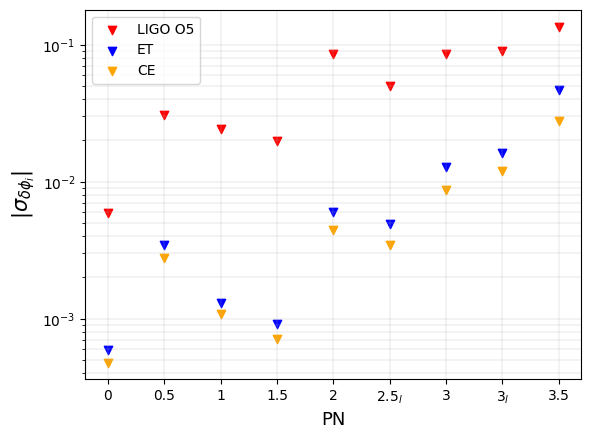

In [ ]:
import matplotlib.ticker as ticker

# Definisci nomi personalizzati per ciascun punto sull'asse x
custom_x_labels = [ '0', '0.5', '1', '1.5', '2', '2.5$_{l}$', '3', '3$_{l}$', '3.5']

fig, ax = plt.subplots()

# Plot dei punti

ax.scatter(x_4, y_4, color='red', marker='v', label = 'LIGO O5')
ax.scatter(x_3, y_3, color='blue', marker='v', label = 'ET')
ax.scatter(x_2, y_2, color='orange', marker='v', label = 'CE')


# Impostazioni degli assi e del titolo
ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\delta \phi_i}|$', fontsize=15)

# Attiva la legenda e la griglia
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='-', linewidth='0.2', which='both')

# Imposta nomi personalizzati sull'asse x
ax.set_xticks(x_2)
ax.set_xticklabels(custom_x_labels)

# Imposta la scala logaritmica sull'asse y
ax.set_yscale('log')

plt.savefig('ppE_O5vsETvsCE.pdf')
# Mostra il grafico
plt.show()

##**|$\sigma_{k_s}$|, |$\sigma_{\lambda_s}$| vs $M$ in a series of events**

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc), redshift e geocent_time
dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]
tc = 1126259462.4

# Definizione dei parametri
parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.5]),
    'a_2': np.array([0.4]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'lambda_1',
                     #'lambda_2'
                     #'k_2',
                     #'k_1'
                     ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

# Definisci il parametro su cui calcolare gli errori
parameter_of_interest = 'lambda_1'

# Definizione dei valori di massa
mass_ratio = 3.
#mass_tot = 70.

results = []
results_2 = []

"""
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)


spin_ratio = 5./4.
spin_tot_start = 0.1
spin_tot_end = 1.
spin_increment = 0.2
"""

mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.


#Mass values
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1., mass_increment):

    """
    a_2 = spin_tot/(1 + spin_ratio)
    a_1 = a_2*spin_ratio

    parameters['a_1'] = a_1
    parameters['a_2'] = a_2
    """
    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [ ]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

data_3 = np.loadtxt('errors_ET_'f'{parameter_of_interest}_3.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

In [ ]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

In [ ]:
#Bayesian
data= np.loadtxt('quadrupole ET.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('quadrupole O5.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

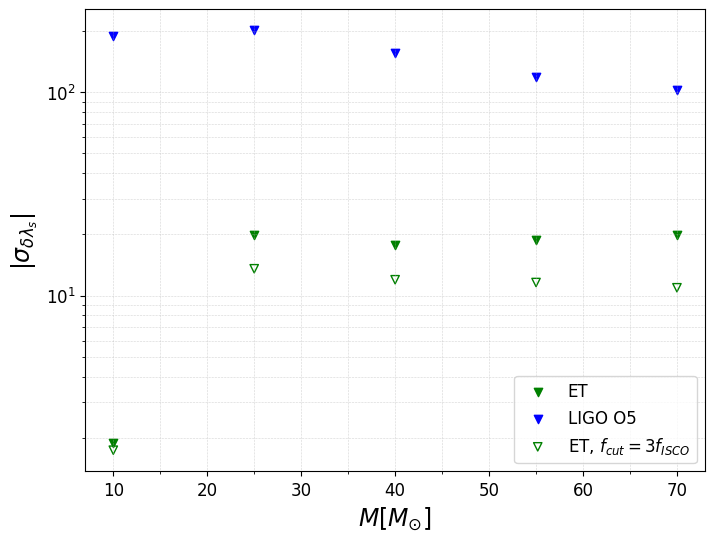

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

# Traccia i dati
ax.scatter(x, y, marker='v', color='g',
           #facecolors='none',
           label='ET')
ax.scatter(x2, y2, marker='v', color='b',
           #facecolors='none',
           label='LIGO O5')
ax.scatter(x_3, y_3, marker='v', color='g',
           facecolors='none',
           label='ET, $f_{cut}=3f_{ISCO}$')
#ax.scatter(x3, y3, marker='v', color='g', label='ET')
#ax.scatter(x4, y4, marker='v', color='b', label='LIGO O5')

# Etichetta gli assi
ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
#ax.set_xlabel('$\chi$', fontsize=17)
#ax.set_ylabel(f'$|\u03C3_{{{parameter_of_interest}}}|$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\delta \lambda_s}|$', fontsize=17)
#ax.set_ylim(10**1, 10**3)

ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=12, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

# Mostra il grafico
plt.grid(True)
plt.savefig(f'_{parameter_of_interest}''_ETvsO5_mul.pdf')
plt.show()

##**|$\sigma_{\Lambda}$| vs $M$ in a series of events**

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc), redshift e geocent_time
dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]
tc = 1126259462.4

# Definizione dei parametri
parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.]),
    'a_2': np.array([0.]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     #'delta_tilde'
                     'tilde'
                     ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

# Definisci il parametro su cui calcolare gli errori
parameter_of_interest = 'tilde'

# Definizione dei valori di massa
mass_ratio_end = 8.
mass_ratio_start = 2.
mass_tot = 70.
mass_increment = 1.

results = []
results_2 = []

#Mass values
for mass_ratio in np.arange(mass_ratio_start, mass_ratio_end + 0.1, mass_increment):

    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_ratio, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_ratio, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_ratio', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_ratio', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [ ]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

In [ ]:
#Bayesian
data= np.loadtxt('tidal 5PN fixed spin gaussian ET.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('tidal 5PN fixed spin gaussian O5.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

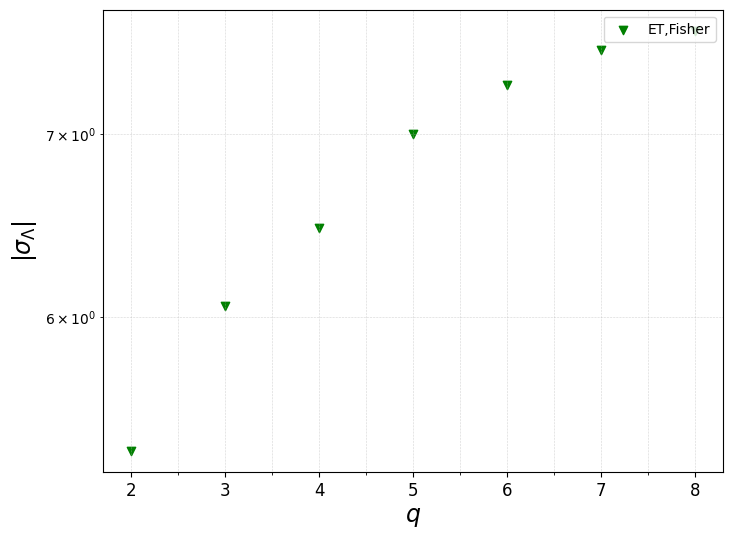

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='ET,Fisher')
#ax.scatter(x2, y2, marker='v', color='b', label='LIGO, Fisher')
#ax.scatter(x3, y3, marker='s', color='g', facecolors='none', label='ET, Bayesian')
#ax.scatter(x4, y4, marker='s', color='b', facecolors='none', label='LIGO, Bayesian')

#ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
ax.set_xlabel('$q$', fontsize=17)
#ax.set_ylabel(f'$|\u03C3_{{{parameter_of_interest}}}|$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\Lambda}|$', fontsize=17)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=10, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
#ax.set_ylim(10**0, 10**2)

plt.grid(True)
plt.savefig('tidal_ETvsO5.pdf')
plt.show()

## **Gaussian priors**

###The  ```compute_network_errors_w_priors``` & ```analyze_and_save_to_txt_w_priors``` functions

In [ ]:
from typing import Optional, Union
import logging
from pathlib import Path

def compute_network_errors_w_priors(
    network: gw.detection.Network,
    parameter_values: pd.DataFrame,
    fisher_parameters: Optional[list[str]] = None,
    prior_values: Optional[list[float]] = None,
    waveform_model: str = gw.waveforms.DEFAULT_WAVEFORM_MODEL,
    waveform_class : type(gw.waveforms.Waveform) = gw.waveforms.LALFD_Waveform,
    use_duty_cycle: bool = False,
    redefine_tf_vectors: bool = False,
    save_matrices: bool = False,
    save_matrices_path: Union[Path, str] = Path('.'),
    matrix_naming_postfix: str = '',
) -> tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:


    if fisher_parameters is None:
        fisher_parameters = list(parameter_values.keys())

    if 'max_frequency_cutoff' in fisher_parameters:
        fisher_parameters.remove('max_frequency_cutoff')

    if 'redshift' in fisher_parameters:
        fisher_parameters.remove('redshift')

    n_params = len(fisher_parameters)
    n_signals = len(parameter_values)

    assert n_params > 0
    assert n_signals > 0

    if isinstance(save_matrices_path, str):
        save_matrices_path = Path(save_matrices_path)

    if save_matrices:
        save_matrices_path.mkdir(parents=True, exist_ok=True)
        fisher_matrices = np.zeros((n_signals, n_params, n_params))
        inv_fisher_matrices = np.zeros((n_signals, n_params, n_params))

    signals_havesky = False
    if ("ra" in fisher_parameters) and ("dec" in fisher_parameters):
        signals_havesky = True
        i_ra = fisher_parameters.index("ra")
        i_dec = fisher_parameters.index("dec")

    detector_snr_thr, network_snr_thr = network.detection_SNR

    parameter_errors = np.zeros((n_signals, n_params))
    if signals_havesky:
        sky_localization = np.zeros((n_signals,))
    network_snr = np.zeros((n_signals,))

    for k in tqdm(range(n_signals)):

        network_fisher_matrix = np.zeros((n_params, n_params))

        prior_matrix = np.zeros((n_params, n_params))
        for i, value in enumerate(prior_values):
            prior_matrix[i, i] = value

        network_snr_square = 0.

        signal_parameter_values = parameter_values.iloc[k]

        for detector in network.detectors:

            detector_fisher, detector_snr_square = gw.fishermatrix.compute_detector_fisher(
                                                        detector,
                                                        signal_parameter_values,
                                                        fisher_parameters,
                                                        waveform_model,
                                                        waveform_class, use_duty_cycle)

            network_snr_square += detector_snr_square

            if np.sqrt(detector_snr_square) > detector_snr_thr:

                network_fisher_matrix += detector_fisher
                network_fisher_matrix += prior_matrix

        network_fisher_inverse, _ = gw.fishermatrix.invertSVD(network_fisher_matrix)

        if save_matrices:
            fisher_matrices[k, :, :] = network_fisher_matrix
            inv_fisher_matrices[k, :, :] = network_fisher_inverse

        parameter_errors[k, :] = np.sqrt(np.diagonal(network_fisher_inverse))

        network_snr[k] = np.sqrt(network_snr_square)

        if signals_havesky:
            sky_localization[k] = gw.fishermatrix.sky_localization_area(
                network_fisher_inverse, parameter_values["dec"].iloc[k], i_ra, i_dec
            )

    detected, = np.where(network_snr > network_snr_thr)

    if save_matrices:

        if matrix_naming_postfix != '':
            if not matrix_naming_postfix.startswith('_'):
                matrix_naming_postfix = f'_{matrix_naming_postfix}'

        fisher_matrices = fisher_matrices[detected, :, :]
        inv_fisher_matrices = inv_fisher_matrices[detected, :, :]

        np.save(save_matrices_path /  f"fisher_matrices{matrix_naming_postfix}.npy", fisher_matrices)
        np.save(save_matrices_path /  f"inv_fisher_matrices{matrix_naming_postfix}.npy", inv_fisher_matrices)

    if signals_havesky:
        return (
            detected,
            network_snr,
            parameter_errors,
            sky_localization,
        )

    return detected, network_snr, parameter_errors, None

In [ ]:
def analyze_and_save_to_txt_w_priors(
    network: gw.detection.Network,
    parameter_values: pd.DataFrame,
    fisher_parameters: list[str],
    sub_network_ids_list: list[list[int]],
    population_name: str,
    save_path: Optional[Union[Path, str]] = None,
    save_matrices: bool = False,
    decimal_output_format: str = '%.3E',
    **kwargs
) -> None:

    if save_path is None:
        save_path = Path().resolve()
    if isinstance(save_path, str):
        save_path = Path(save_path)

    for sub_network_ids in sub_network_ids_list:

        partial_network = network.partial(sub_network_ids)

        filename = gw.fishermatrix.errors_file_name(
            network=network,
            sub_network_ids=sub_network_ids,
            population_name=population_name,
        )

        detected, network_snr, errors, sky_localization = compute_network_errors_w_priors(
            network=partial_network,
            parameter_values=parameter_values,
            fisher_parameters=fisher_parameters,
            prior_values=prior_values,
            save_matrices=save_matrices,
            save_matrices_path=save_path,
            matrix_naming_postfix='_'.join(filename.split('_')[1:]),
            **kwargs,
        )

        gw.fishermatrix.output_to_txt_file(
            parameter_values=parameter_values.iloc[detected],
            network_snr=network_snr[detected],
            parameter_errors=errors[detected, :],
            sky_localization=(
                sky_localization[detected] if sky_localization is not None else None
            ),
            fisher_parameters=fisher_parameters,
            filename=save_path/filename,
            decimal_output_format=decimal_output_format,
        )

### *GW150914 LIGO O1 comparison between GWFISH and BILBY*

In [ ]:
detectors_3 = ['LLO_O1','LHO_O1']
network_3 = gw.detection.Network(detector_ids = detectors_3, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE

z = np.array([0.088])
i = 0.

i_min = 0
i_max = 11

results = []

for i in np.arange(i_min, i_max, 1):
    if i == 5:
        continue  # Salta l'iterazione quando i = 5

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)

    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = 0.68/1.645
    prior_a1 = 1/(2*delta_a1**2)

    delta_a2 = 0.56/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    delta_theta = 0.7/1.645
    prior_theta = 1/(2*delta_theta**2)

    delta_phi = 20/1.645
    prior_phi = 1/(2*delta_phi**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta,
                    prior_phase,
                    prior_phi
                    #0.]
    ]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network_3,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])

results_df = pd.DataFrame(results, columns=['i', f'err_delta_phi', 'network_snr'])

#Storage
detector_name = '_'.join(detectors_3)

file_name = f'errors_{detector_name}_delta_phi_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)

#delta_phi_8=delta_phi_2.5log
#delta_phi_9=delta_phi_3log
#delta_phi_10=delta_phi_-1

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


### *GW150914 O5, ET, CE comparison*

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
detectors_3 = ['CE1', 'CE2']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
network_3 = gw.detection.Network(detector_ids = detectors_3, detection_SNR = (0., 8.))


waveform_model_2 = 'IMRPhenomD_PPE'
waveform_class_2 = gw.inspiral_corrections.IMRPhenomD_PPE

z = np.array([0.088])
i = 0.

i_min = 0
i_max = 11

results = []
results_2 = []
results_3 = []

for i in np.arange(i_min, i_max, 1):
    if i == 5:
        continue  # Salta l'iterazione quando i = 5

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)

    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = 0.68/1.645
    prior_a1 = 1/(2*delta_a1**2)

    delta_a2 = 0.56/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    delta_theta = 0.7/1.645
    prior_theta = 1/(2*delta_theta**2)

    delta_phi = 20/1.645
    prior_phi = 1/(2*delta_phi**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta,
                    prior_phase,
                    prior_phi
                    #0.]
    ]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    detected_3, network_snr_3, parameter_errors_3, sky_localization_3 = compute_network_errors_w_priors(
        network=network_3,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([i, err_parameter_of_interest_2, network_snr_2])

    err_parameter_of_interest_3 = 1.645 * np.squeeze(parameter_errors_3)[fisher_parameters.index(parameter_of_interest)]
    results_3.append([i, err_parameter_of_interest_3, network_snr_3])

results_df = pd.DataFrame(results, columns=['i', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['i', f'err_{parameter_of_interest}_2', 'network_snr_2'])
results_df_3 = pd.DataFrame(results_3, columns=['i', f'err_{parameter_of_interest}_3', 'network_snr_3'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
detector_name_3 = '_'.join(detectors_3)

file_name = f'errors_{detector_name}_delta_phi.txt'
file_name_2 = f'errors_{detector_name_2}_delta_phi.txt'
file_name_3 = f'errors_{detector_name_3}_delta_phi.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)
results_df_3.to_csv(file_name_3, sep='\t', index=False)

100%|██████████| 1/1 [00:11<00:00, 11.68s/it]


### $k_s,\tilde\Lambda$ vs $M$ in a series of events

In [ ]:
from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc) e il geocent_time
dL = 400.
tc = 1126259462.4

# Definizione dei parametri
parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.5]),
    'a_2': np.array([0.4]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.])
}

parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'lambda_1',
                     #'lambda_2'
                     #'k_2',
                     #'k_1'
                     #'tilde'
                     ]

"""
prior_values = [0., 0.,
                0., 0.,
                0.,
                0., 0.,
                0.
                ]
"""
waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

parameter_of_interest = 'lambda_1'

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway


# Definizione dei valori di massa
mass_ratio = 3.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

# Ricerca della radice dell'equazione redshift-distanza di luminosità
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Inizializzazione della lista per memorizzare i risultati
results = []
results_2 = []

# Iterazione su mass_1
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    # Calcolo di mass_1 e mass_2 basato su q e M
    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    # Aggiornamento dei parametri con i nuovi valori di massa
    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)

    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = 0.5/1.645
    prior_a1 = 1/(2*delta_a1**2)

    delta_a2 = 0.6/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    delta_theta = 0.7/1.645
    prior_theta = 1/(2*delta_theta**2)

    delta_lambda = 200/1.645
    prior_lambda = 1/(2*delta_lambda**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta,
                    prior_phase,
                    prior_lambda
                    #0.]
    ]

    # Calcolo degli errori sui parametri con i nuovi valori di massa
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

# Salva i risultati in un file di testo .txt
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}_w_priors.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [ ]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

In [ ]:
data = np.loadtxt('tidal 5PN zero spin gaussian ET.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('tidal 5PN zero spin gaussian O5.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

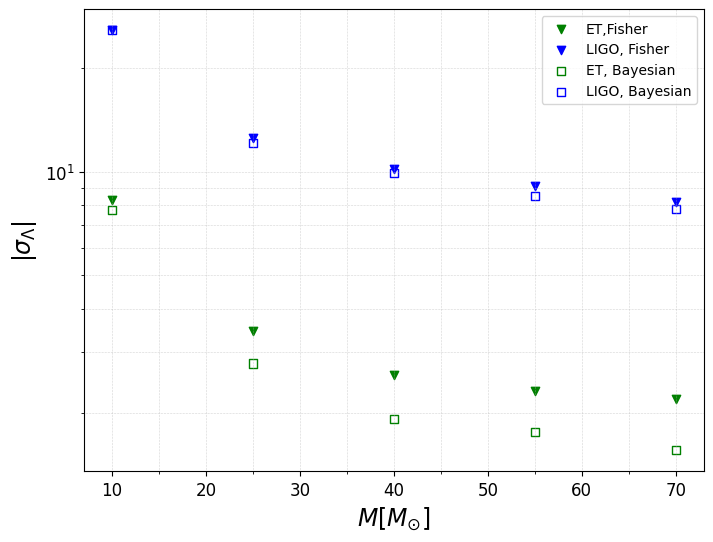

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='ET,Fisher')
ax.scatter(x2, y2, marker='v', color='b', label='LIGO, Fisher')
ax.scatter(x3, y3, marker='s', color='g', facecolors='none', label='ET, Bayesian')
ax.scatter(x4, y4, marker='s', color='b', facecolors='none', label='LIGO, Bayesian')

ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
#ax.set_ylabel(f'$|\u03C3_{{{parameter_of_interest}}}|$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\Lambda}|$', fontsize=17)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=10, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
#ax.set_ylim(10**0, 10**2)

plt.grid(True)
plt.savefig('tidal_ETvsO5.pdf')
plt.show()

### Corner plot

In [ ]:
#detectors = ['LLO','LHO']
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc) e il geocent_time
dL = 400.
tc = 1126259462.4

# Definizione dei parametri
parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.]),
    'a_2': np.array([0.]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde' : np.array([0.])
}

parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     #'lambda_1',
                     #'lambda_2'
                     #'k_2',
                     #'k_1'
                     'tilde'
                     ]

mass_ratio = 3.
mass_tot = 70.

# Ricerca della radice dell'equazione redshift-distanza di luminosità
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Calcolo di mass_1 e mass_2 basato su q e M
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

delta_m1 = (parameters['mass_1']*0.5)/1.645
prior_m1 = 1/(2*delta_m1**2)

delta_m2 = (parameters['mass_2']*0.5)/1.645
prior_m2 = 1/(2*delta_m2**2)

delta_a1 = 0.3/1.645
prior_a1 = 1/(2*delta_a1**2)

delta_a2 = 0.3/1.645
prior_a2 = 1/(2*delta_a2**2)

delta_dL = 290./1.645
prior_dL = 1/(2*delta_dL**2)

delta_phase = 2.*np.pi/1.645
prior_phase = 1/(2*delta_phase**2)

delta_theta = 0.7/1.645
prior_theta = 1/(2*delta_theta**2)

delta_lambda = 200/1.645
prior_lambda = 1/(2*delta_lambda**2)

prior_values = [prior_m1, prior_m2,
                prior_a1, prior_a2,
                prior_dL, prior_theta,
                prior_phase,
                prior_lambda
                #0.]
    ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

In [ ]:
# Definizione dei valori di massa
mass_ratio = 3.
mass_tot = 70.

# Calcolo di mass_1 e mass_2 basato su q e M
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Ricerca della radice dell'equazione redshift-distanza di luminosità
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

data_folder = 'gwfish_results'
analyze_and_save_to_txt_w_priors(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0]],
                                        population_name = 'Tidal',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


In [ ]:
! pip install -q corner
import corner

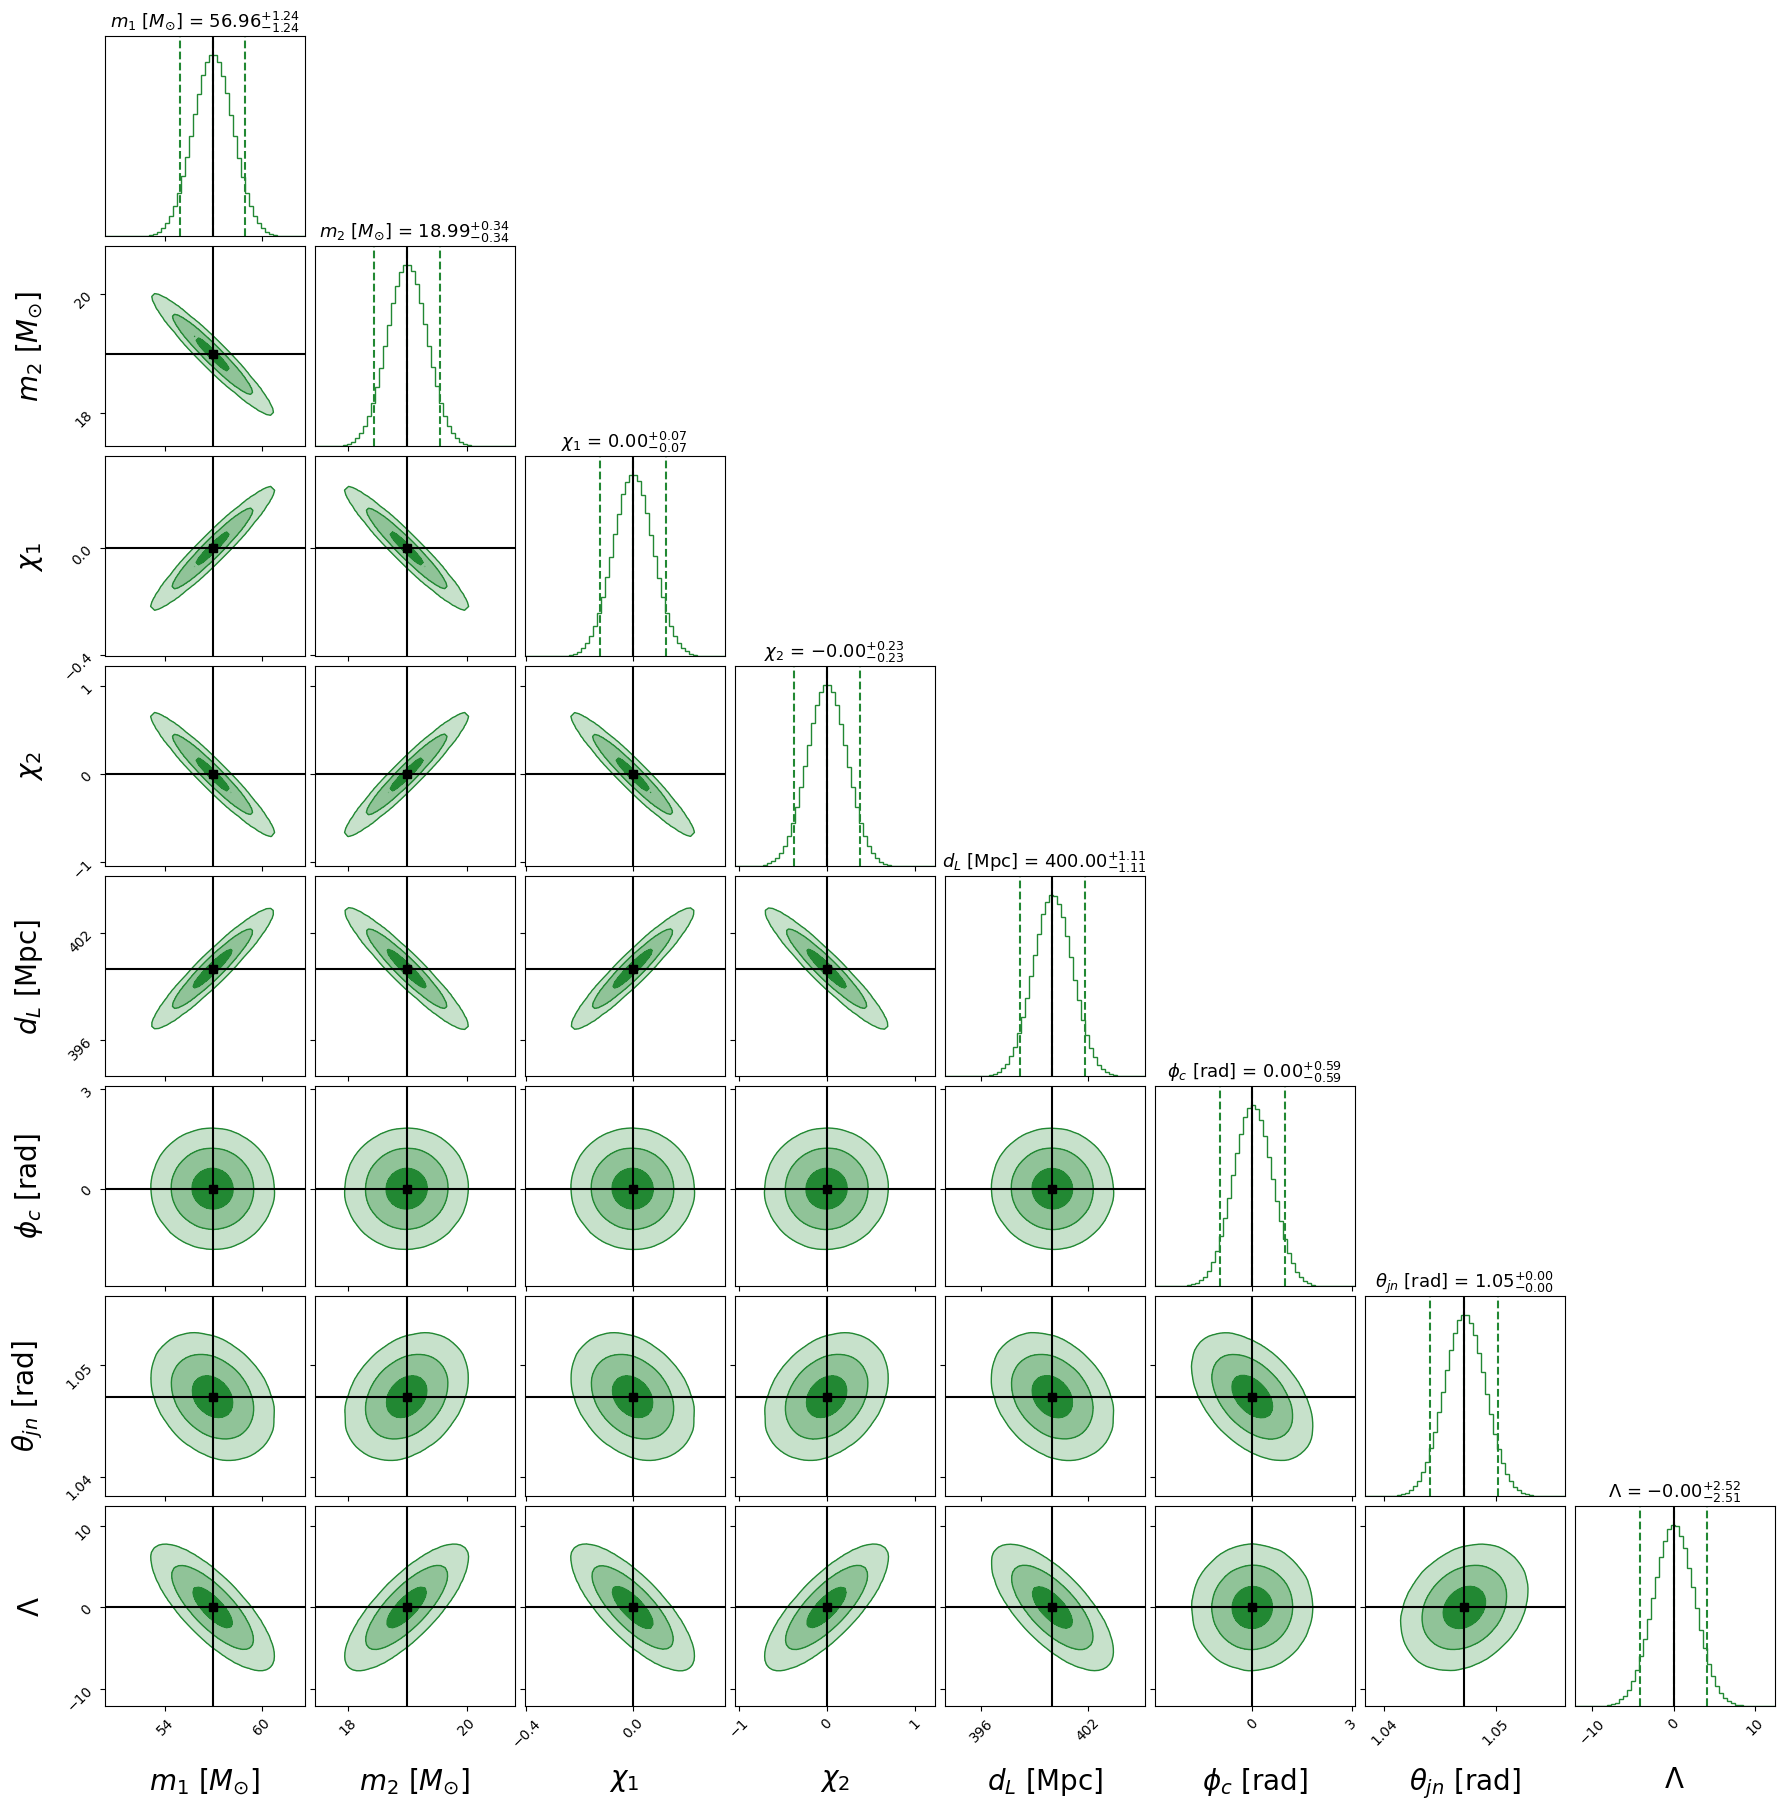

In [ ]:
CORNER_KWARGS = dict(
    color="#228833", #Green
    #color="#EE6677", #Red
    #color = "#4477AA", #Blue
    truth_color='black',
    #truth_color='red',
    bins = 50,
    smooth = 1.1,
    plot_datapoints = False,
    label_kwargs = dict(fontsize = 20),
    show_titles = True,
    title_kwargs = dict(fontsize = 13),
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours = True,
    max_n_ticks = 2,
    title_fmt=".2f",
    contour_kwargs={'linewidths':1},
    hist_kwargs = {'linewidth':1},
    quantiles=(0.05,0.5,0.95)
    )

corner_lbs = ['$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$',
              r'$\chi_1$', r'$\chi_2$',
              '$d_L$ [Mpc]',
              '$\phi_c$ [rad]',
              r'$\theta_{jn}$ [rad]',
              #'$t_c$ [GPS]', '$\Psi$'
              #r'$\delta \varphi_0$'
              #r'$\kappa_s$'
              #r'$\beta$'
              r'$\Lambda$'
              ]

mean_lbs = ['mass_1', 'mass_2',
            'a_1', 'a_2',
            'luminosity_distance',
            'phase',
            'theta_jn',
            #'geocent_time', 'psi'
            #'delta_phi_0'
            #'k_1'
            #'beta'
            'tilde'
            ]

mean_values = parameters[mean_lbs].iloc[0]
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_ET_Tidal_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

selected_indices = [0, 1, 2, 3, 4, 5, 6, 7]
selected_samples = samples[:, selected_indices]
selected_labels = [corner_lbs[i] for i in selected_indices]
selected_mean_values = mean_values[selected_indices]

fig = corner.corner(selected_samples, labels=selected_labels,
                    truths=selected_mean_values,
                    **CORNER_KWARGS)

plt.savefig('corner.pdf')
plt.show()

## **Geocentric time and time at coalescence**

In [ ]:
detectors = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc)
dL = 400.

# Definisci il redshift
z = 0.088

tc = 1126259462.4

# Definizione dei parametri

parameters = {
    'redshift': z,
    'luminosity_distance': np.array([dL]),

    'a_1':np.array([0.9]),
    'a_2':np.array([0.8]),

    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),

    'cut': np.array([2.]),

    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)


# Definizione di eventuali valori di mass ratio e massa totale
mass_ratio = 3.
mass_tot = 25.

# Calcolo di mass_2 basato sul rapporto di massa
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Ricerca della radice dell'equazione redshift-distanza di luminosità
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)


fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'k_1'
                     ]


fisher_parameters_2 = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'k_1'
                     ]


waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'


detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
network=network,
parameter_values=parameters,
fisher_parameters=fisher_parameters,
waveform_model = waveform_model,
waveform_class = waveform_class
)
err_k_1 = np.squeeze(parameter_errors)[fisher_parameters.index('k_1')]

detected, network_snr_2, parameter_errors_2, sky_localization = gw.fishermatrix.compute_network_errors(
network=network,
parameter_values=parameters,
fisher_parameters=fisher_parameters_2,
waveform_model = waveform_model,
waveform_class = waveform_class
)
err_k_1_wo_tc = np.squeeze(parameter_errors_2)[fisher_parameters_2.index('k_1')]


################################################################################
print('\n      z =', z)
print('\n      M [M_sol] =', mass_tot, '      q =', mass_ratio)
print('\n      a_1 =', parameters['a_1'].values[0], '      a_2 =', parameters['a_2'].values[0])
print('\n      d_l [Mpc] =', parameters['luminosity_distance'].values[0], '      theta_jn [rad]=', parameters['theta_jn'].values[0])
print('\n      ra [rad] =', parameters['ra'].values[0], '      dec [rad] =', parameters['dec'].values[0])
print('\n      phi_c =', parameters['phase'].values[0], '      t_c =', parameters['geocent_time'].values[0])

print('\n\n The network SNR of the event is', network_snr)
print('\n\n The symmetric quadrupole deviation error of the event is')
print('\n\n delta k_s =', err_k_1)

print('\n\n The network SNR of the event, at fixed t_c, is', network_snr_2)
print('\n\n The symmetric quadrupole deviation error, at fixed t_c, of the event is')
print('\n\n delta k_s =', err_k_1_wo_tc)

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


      z = 0.08491816057699987

      M [M_sol] = 25.0       q = 3.0

      a_1 = 0.9       a_2 = 0.8

      d_l [Mpc] = 400.0       theta_jn [rad]= 1.0471975511965976

      ra [rad] = 4.0       dec [rad] = -0.5

      phi_c = 0.0       t_c = 1126259462.4


 The network SNR of the event is [67.71625989]


 The symmetric quadrupole deviation error of the event is


 delta k_s = 0.7467540553019053


 The network SNR of the event, at fixed t_c, is [67.71625989]


 The symmetric quadrupole deviation error, at fixed t_c, of the event is


 delta k_s = 0.5177160370722665


In [ ]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve

def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci il geocent_time
#tc = 1126259462.4
tc = 0.

dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1':np.array([0.9]),
    'a_2':np.array([0.8]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),

    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}

parameters = pd.DataFrame(parameters)

#Fisher parameters dictionary

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'theta_jn',
                     'phase', 'geocent_time',
                     #'dec','ra',
                     #'psi',
                     #'k_1'
                    ]

fisher_parameters_2 = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'theta_jn',
                     'phase',
                     #'dec','ra',
                     #'psi',
                     #'k_1'
                    ]

waveform_class = gw.waveforms.LALFD_Waveform
waveform_model = 'TaylorF2'

# Definizione dei valori di massa
mass_ratio = 3.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

# Inizializzazione della lista per memorizzare i risultati
results = []
results_2 = []

# Iterazione su mass_1
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    # Calcolo di mass_1 e mass_2 basato su q e M
    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    # Aggiornamento dei parametri con i nuovi valori di massa
    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    # Calcolo degli errori sui parametri con i nuovi valori di massa
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters_2,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    # Definisci il parametro su cui calcolare gli errori
    parameter_of_interest = 'mass_1'

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters_2.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

# Salva i risultati in un file di testo .txt
file_name = f'errors_w_geocent_time_{parameter_of_interest}.txt'
file_name_2 = f'errors_wo_geocent_time_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


In [ ]:
data = np.loadtxt('errors_w_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_wo_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

In [ ]:
data = np.loadtxt('errors_w_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('errors_wo_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

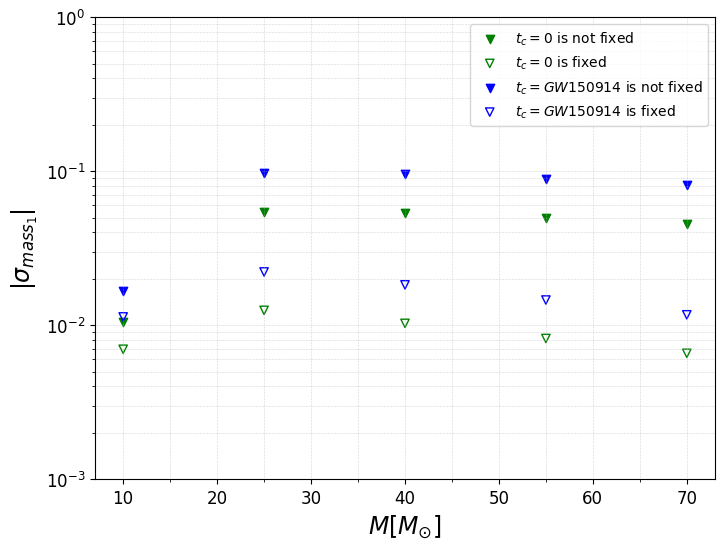

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='$t_c=0$ is not fixed')
ax.scatter(x2, y2, marker='v', color='g', facecolors='none', label='$t_c=0$ is fixed')
ax.scatter(x3, y3, marker='v', color='b', label='$t_c=GW150914$ is not fixed')
ax.scatter(x4, y4, marker='v', color='b', facecolors='none', label='$t_c=GW150914$ is fixed')

ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
ax.set_ylabel(f'$|\u03C3_{{{parameter_of_interest}}}|$', fontsize=17)
ax.set_yscale('log')
ax.set_ylim(10**(-3), 10**0)
ax.legend(loc='upper right', fontsize=10, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
plt.show()

## The ```analyze_and_save_to_txt``` function: save results to file and more

In [ ]:
!mkdir gwfish_results

The difference with respect to the ```compute_network_errors``` function is that one can pass different network combinations and get results files for each of them. This means that if your detectors list is something like ```['LHO', 'LLO', 'VIR', 'CE1', 'ET']``` and you want to create 3 different networks out of it, i.e. ```['LHO', 'LLO', 'VIR']```, ```['CE1', 'ET']``` and ```['ET']``` alone, then one should inizialize the ```analyze_and_save_to_txt``` function as follows:

```
network = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))
```

and then specify the different network combinations:

```
sub_network_ids_list = [[0, 1, 2], [3, 4], [4]]
```

###**Single event example**

In [ ]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc) e il geocent_time
z = 0.088
tc = 1126259462.4

parameters = {
    'a_1': np.array([0.32]),
    'a_2': np.array([0.34]),
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase','psi','geocent_time',
                     #'ra','dec',
                     'luminosity_distance','theta_jn',
                     ]

waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE
waveform_model = 'IMRPhenomD_PPE'


# Definizione dei valori di massa
mass_ratio = 1.2
mass_tot = 50.

# Calcolo di mass_1 e mass_2 basato su q e M
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0]],
                                        population_name = 'GW150914',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


In [ ]:
fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_GW150914_SNR8.npy')
errors = pd.read_csv(data_folder + '/' + 'Errors_ET_GW150914_SNR8.txt', delimiter = ' ')

# One can access all the column names of the errors output file:
errors.keys()
errors

,network_SNR,a_1,a_2,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,...,mass_2,err_mass_1,err_mass_2,err_a_1,err_a_2,err_phase,err_psi,err_geocent_time,err_luminosity_distance,err_theta_jn
0,819.605135,0.32,0.34,415.4,2.421,1.7,-1.2,0.0,0.0,1.126000e+09,...,24.73,0.09918,0.07982,0.03634,0.04653,0.06421,0.01566,0.00018,3.418,0.01033


### **$SNR$ - $d_L$ test**



One would expect that the Fisher matrix entry corresponding to dL-dL should be approximated by the ratio between the SNR and the luminosity distance squared as follows:

$$
\frac{1}{SNR} = \frac{\Delta d_L}{d_L}
$$

where $\Delta d_L = \sqrt{\left[F\right]^{-1}_{d_L,d_L}}$, with $F$ the Fisher matrix.

This can be derived from the fact that $\partial_{d_L}h = -\frac{1}{d_L}h$ and
$$\frac{1}{\left(\Delta d_L\right)^2} \sim F_{d_L,d_L}=\langle \partial_{d_L}h|\partial_{d_L}h\rangle \sim \frac{SNR^2}{d_L^2}$$

where the inverse of the error on distance is the corresponding entry of the Fisher matrix $F_{d_L,d_L}$ (assuming correlations are negligible).

A rough approximation in literature takes: $\frac{\Delta d_L}{d_L} \sim \frac{2}{SNR}$.

In [ ]:
my_fisher = fisher_matrix[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', my_fisher[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)
print('(SNR*Delta dL)/dL: ', (errors['network_SNR'].iloc[0] * errors['err_luminosity_distance'].iloc[0] / errors['luminosity_distance'].iloc[0]))

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  7317733683.941786
(SNR/dL)^2:  3.892927871551197
(SNR*Delta dL)/dL:  6.743886259067549


In [ ]:
# Detector

#detectors = ['ET']
detectors = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

# Waveform approximant

waveform_class = gw.waveforms.TaylorF2
waveform_model = 'TaylorF2'

LIGO_results=[]

# Series of events

for mass_tot in mass_tot_values:

    mass_2 = mass_tot / (1 + mass_ratio)
    mass_1 = mass_2 * mass_ratio

    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    data_folder = 'Gwfish_results'
    gw.fishermatrix.analyze_and_save_to_txt(network=network,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class,
                                            waveform_model=waveform_model,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_LLO_GW150914_SNR8.npy')
    my_fisher = fisher_matrix[0, :, :]
    #errors = pd.read_csv(data_folder + '/' + 'Errors_ET_GW150914_SNR8.txt', delimiter=' ')
    errors = pd.read_csv(data_folder + '/' + 'Errors_LLO_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors['network_SNR'].iloc[0] / (my_fisher[2, 2]*errors['luminosity_distance'].iloc[0])

    LIGO_results.append((mass_tot, snr_times_delta_dL))

# GWFish results
with open('SNR_test_GWFish.txt', 'w') as f:
    for result in LIGO_results:
        f.write(f'{result[0]} {result[1]}\n')

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


In [ ]:
# Lal default

ET_results=[]

detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

# Series of events

for mass_tot in mass_tot_values:

    mass_2 = mass_tot / (1 + mass_ratio)
    mass_1 = mass_2 * mass_ratio

    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    data_folder = 'Lal_results'
    gw.fishermatrix.analyze_and_save_to_txt(network=network,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class,
                                            waveform_model=waveform_model,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix_2 = np.load(data_folder + '/' + 'fisher_matrices_ET_GW150914_SNR8.npy')
    my_fisher_2 = fisher_matrix_2[0, :, :]
    errors_2 = pd.read_csv(data_folder + '/' + 'Errors_ET_GW150914_SNR8.txt', delimiter=' ')
    #errors_2 = pd.read_csv(data_folder + '/' + 'Errors_LLO_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors_2['network_SNR'].iloc[0] / (my_fisher_2[2, 2] * errors_2['luminosity_distance'].iloc[0] )

    ET_results.append((mass_tot, snr_times_delta_dL))

# Lal results
with open('SNR_test_Lal.txt', 'w') as f:
    for result in ET_results:
        f.write(f'{result[0]} {result[1]}\n')

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


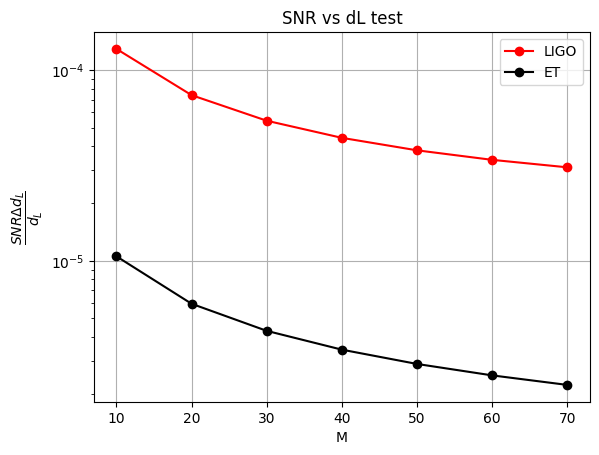

In [ ]:
GWFish_results = np.loadtxt('SNR_test_GWFish.txt')
Lal_results = np.loadtxt('SNR_test_Lal.txt')

# Fai il plot dei risultati
plt.plot(GWFish_results[:,0], GWFish_results[:,1], marker='o', color='red', label='LIGO')
plt.plot(Lal_results[:,0], Lal_results[:,1], marker='o', color='black', label='ET')

plt.xlabel('M')
plt.ylabel('$\dfrac{SNR \Delta d_L}{d_L}$')
plt.title('SNR vs dL test')
plt.grid(True)
plt.yscale('log')
plt.legend()  # Mostra la legenda

# Maybe, for M <= 30 M_sun LIGO doesn't work very well. fmin = 20 Hz
#plt.xlim(40,70)

plt.show()

### **Corner plot**

Using the covariance matrix one show all the correlations between pairs of parameters in a corner plot. Using as inputs the injected values and the covariance matrix, one samples from a multivariate Gaussian distribution and plot the samples.

In [ ]:
! pip install -q corner

In [ ]:
import corner

In [ ]:
detectors = ['LLO','LHO']
#detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc), il geocent_time e redshift
dL = 400.
tc = 1126259462.4
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Definizione dei parametri
parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.9]),
    'a_2': np.array([0.8]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}

parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     #'lambda_1',
                     #'lambda_2'
                     #'k_2',
                     #'k_1'
                     #'delta_tilde'
                     'tilde'
                     ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

# Definizione dei valori di massa
mass_ratio = 3.
mass_tot = 70.

# Calcolo di mass_1 e mass_2 basato su q e M
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0,1]],
                                        population_name = 'Tidal',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


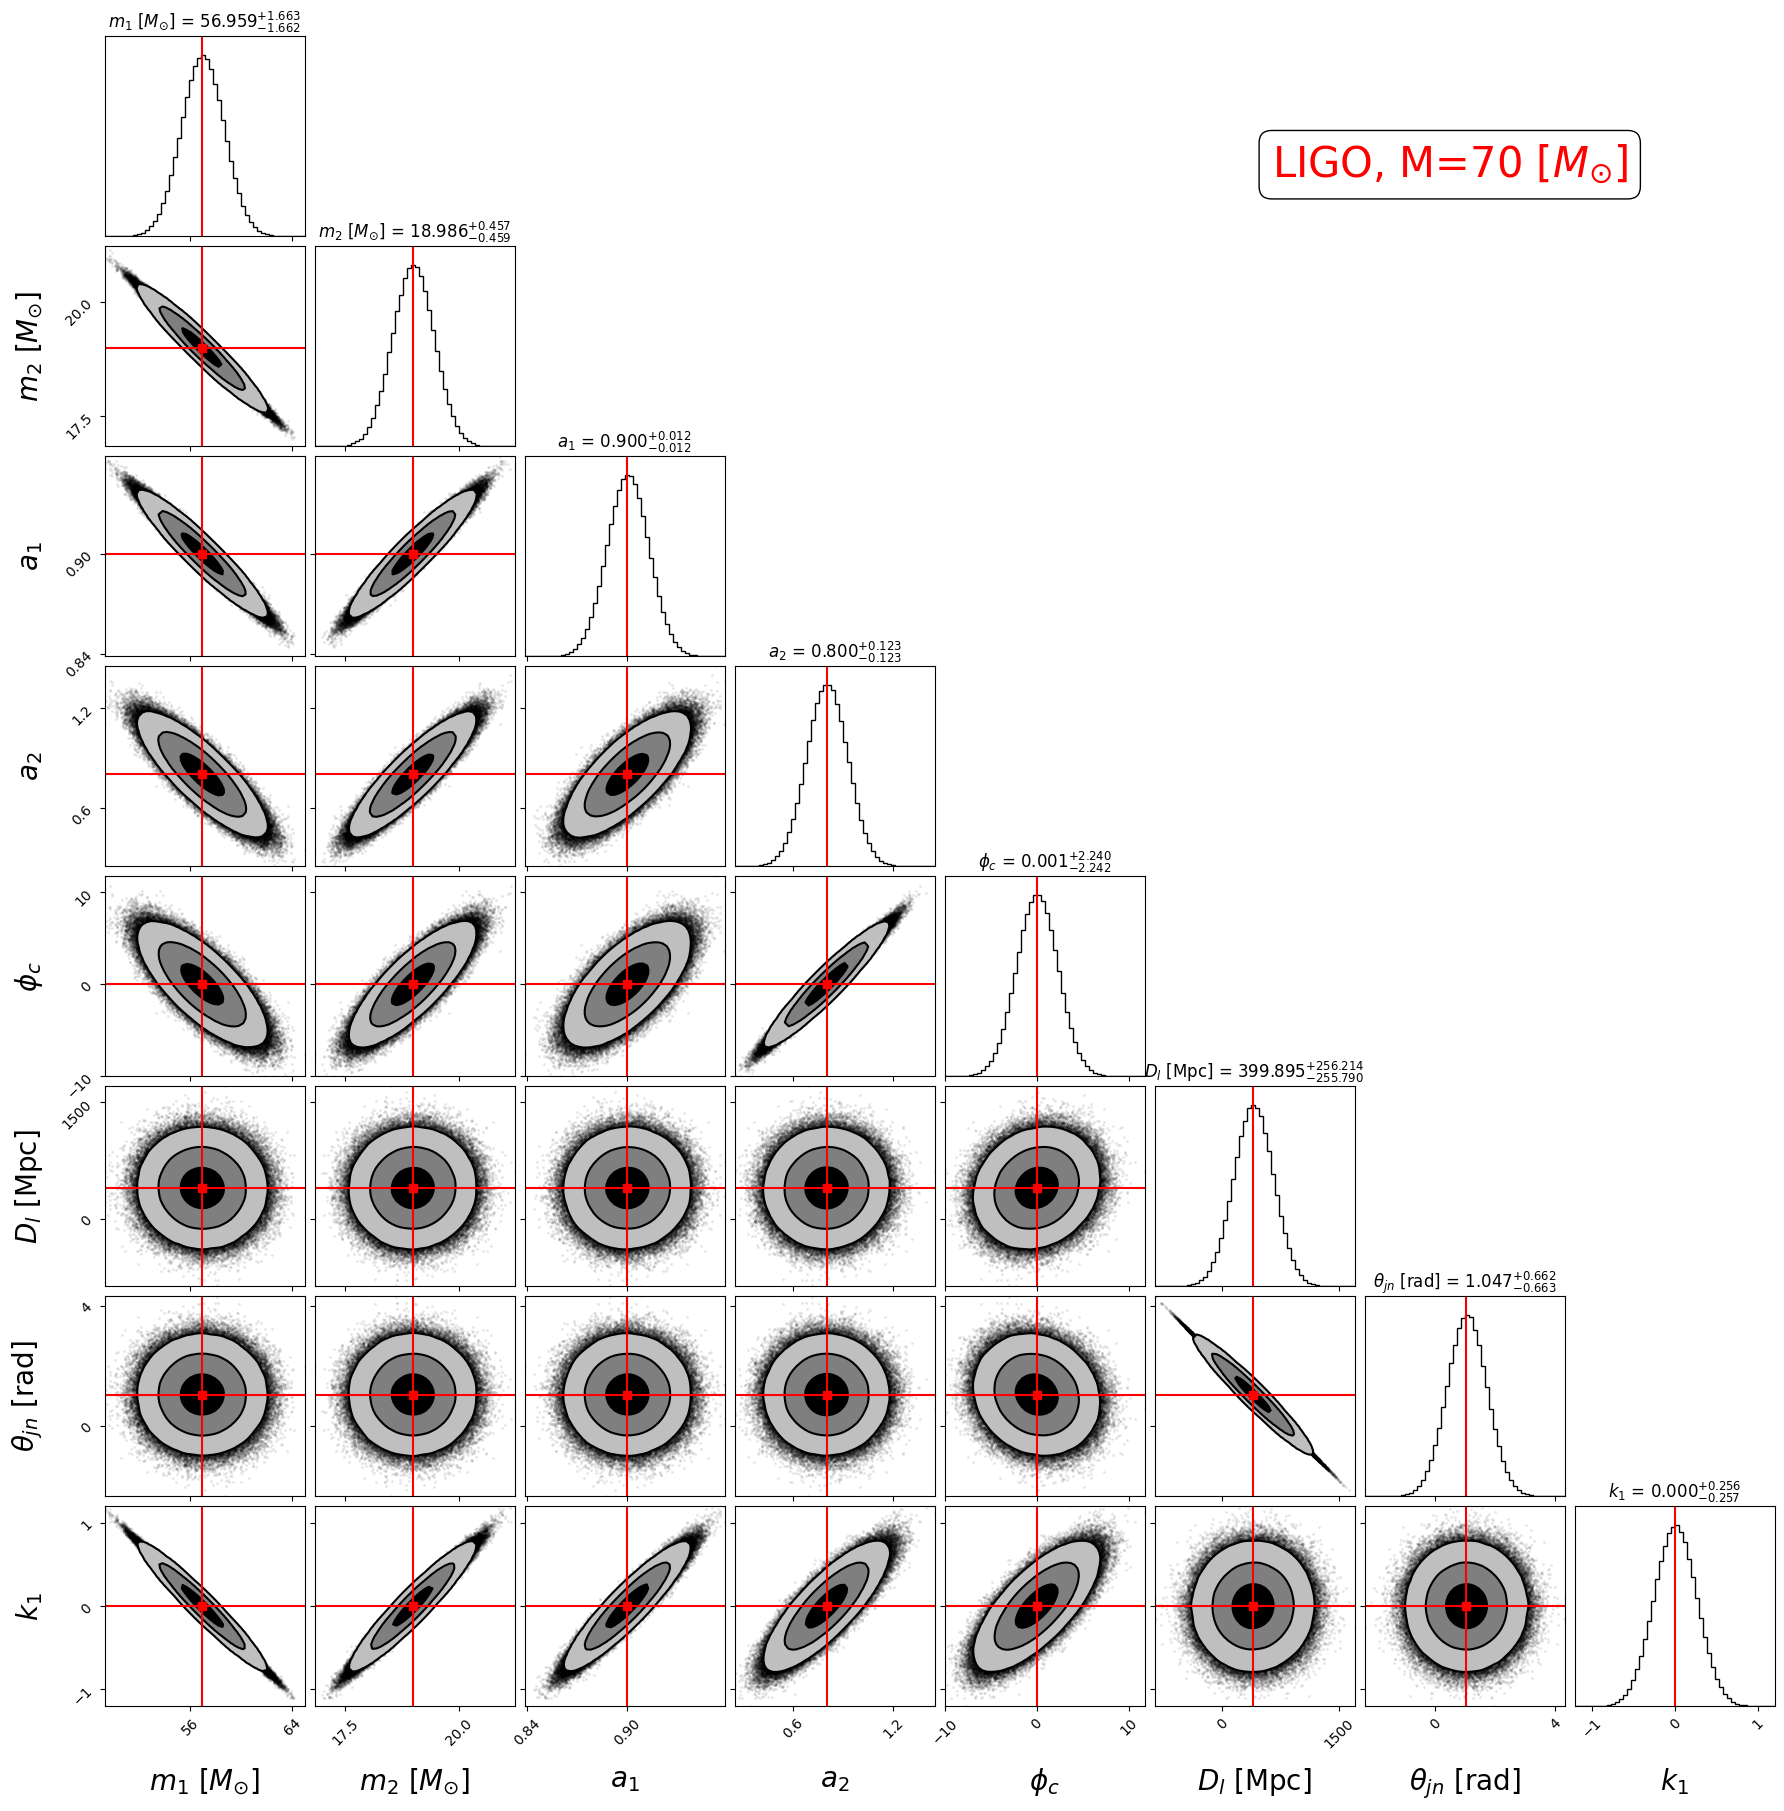

In [ ]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours.
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 20), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )

corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$','$a_1$', '$a_2$',
              '$\phi_c$',
              '$D_l$ [Mpc]', '$\u03b8_{jn}$ [rad]',
              #'$k_2$',
              #'$k_1$'
              #'$\delta \Lambda$'
              '$\Lambda$'
              ]

mean_lbs = ['mass_1', 'mass_2', 'a_1', 'a_2',
            'phase',
            #'geocent_time',
            'luminosity_distance','theta_jn',
            #'lambda_1'
            #'lambda_2'
            #'k_2',
            #'k_1'
            #'delta_tilde'
            'tilde',
            ]

mean_values = parameters[mean_lbs].iloc[0]  #mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_LLO_LHO_Tidal_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))
fig = corner.corner(samples, labels=corner_lbs, truths=mean_values, truth_color='red', **CORNER_KWARGS)

# Costruisci un riquadro intorno al testo
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
plt.text(0.7, 0.9, 'LIGO, M=70 $[M_{\odot}]$', color='red', fontsize=30, transform=fig.transFigure, bbox=bbox_props)

plt.savefig('corner.pdf')
plt.show()

# **BBH Population Analysis**
The functions are the same explained in the previous tutorial, but applied to a population sample instead of a single event

In [ ]:
detectors_pop = ['ET']
network_pop = gw.detection.Network(detector_ids = detectors_pop, detection_SNR = (0., 8.))
waveform_model_pop = 'IMRPhenomHM'
fisher_parameters_pop = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2']

In [ ]:
data_file = 'my_sample_BBH_data' # or 'my_sample_BNS_data' for BNS population sample
pop_file_url = 'https://raw.githubusercontent.com/u-dupletsa/ET-ad-Assisi-2024-Scienza-e-Tecnologia/main/data/' + data_file + '.txt'

In [ ]:
bbh_data = pd.read_csv(pop_file_url, delimiter = ' ')
bbh_df = pd.DataFrame(bbh_data)
bbh_df

In [ ]:
!mkdir pop_gwfish_results

In [ ]:
data_folder_pop = 'pop_gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                        parameter_values  = bbh_df,
                                        fisher_parameters = fisher_parameters_pop,
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BBH',
                                        waveform_model = waveform_model_pop,
                                        save_path = data_folder_pop,
                                        save_matrices = False)

In [ ]:
pop_errors = pd.read_csv(data_folder_pop + '/' + 'Errors_ET_BBH_SNR8.txt', delimiter = ' ')
pop_errors

In [ ]:
plt.hist(pop_errors['network_SNR'], bins = 10, color = 'blue', alpha = 0.5, linewidth = 2)
plt.xlabel('Network SNR')
plt.ylabel('Number of events')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(pop_errors['mass_1'], bins = 15, label = 'mass_1', alpha= 0.5)
plt.hist(pop_errors['mass_2'], bins = 15, label = 'mass_2', alpha= 0.5)
plt.legend()
plt.xlabel('mass [$M_{\odot}$]')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

In [ ]:
percentile_pop = 90
sky_loc_90cl_pop = pop_errors['err_sky_location'] * gw.fishermatrix.sky_localization_percentile_factor(percentile_pop)
sc = plt.scatter(pop_errors['err_luminosity_distance'] / pop_errors['luminosity_distance'],
                 sky_loc_90cl_pop, c = pop_errors['network_SNR'], cmap = 'inferno')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{%s}$' %int(percentile))
plt.colorbar(sc, label = 'SNR')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

## Some more exercises

### 1. Analyze BNS population

After loading the BNS population, do the Fisher analysis and redo the plots done for the BBH population

In [ ]:
data_file = 'my_sample_BNS_data'
bns_pop_url = 'https://raw.githubusercontent.com/u-dupletsa/ET-ad-Assisi-2024-Scienza-e-Tecnologia/main/data/' + data_file + '.txt'
bns_data = pd.read_csv(bns_pop_url, delimiter = ' ')
bns_data = pd.DataFrame(bns_data)
bns_data

### 2. Create your own population

Follow the guidelines to create your own population sample and run it with GWFish:

In [ ]:
# Example for BNS population
nev = 50 # number of events
my_dict = {}
my_dict['redshift'] = np.random.uniform(0.001, 0.1, nev)
my_dict['mass_1'] = np.random.uniform(1.1, 2.5, nev)
my_dict['mass_2'] = np.random.uniform(1.1, 2.5, nev)
my_dict['luminosity_distance'] = Planck18.luminosity_distance(my_dict['redshift']).value
my_dict['theta_jn'] = np.arccos(np.random.uniform(-1., 1., nev))
my_dict['ra'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
my_dict['psi'] = np.random.uniform(0., np.pi, nev)
my_dict['phase'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['geocent_time'] = np.random.uniform(1577491218, 1609027217, nev)
my_dict['a_1'] = np.random.uniform(0., 0.1, nev)
my_dict['a_2'] = np.random.uniform(0., 0.1, nev)
my_dict['lambda_1'] = np.random.uniform(100., 1000., nev)
my_dict['lambda_2'] = np.random.uniform(100., 1000., nev)
aux_mass = my_dict['mass_1']
my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])
my_dict = pd.DataFrame(my_dict)
my_dict